In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Loading processed data
train_df = pd.read_csv("data/train_processed.csv")
test_df = pd.read_csv("data/test_processed.csv")

# Basic information
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nTraining data columns:")
print(train_df.columns.tolist())

Training data shape: (891, 21)
Test data shape: (418, 20)

Training data columns:
['deck', 'age_pclass', 'family_size_pclass', 'woman_or_child', 'sex', 'rich_woman', 'is_shared_ticket', 'sex_pclass', 'fare', 'title', 'is_alone_sex', 'age', 'has_cabin', 'fare_per_person', 'fare_group', 'age_sex', 'pclass', 'fare_pclass', 'family_category_small_family', 'fare_per_person_group', 'survived']


In [2]:
# Preparing data for modeling
X = train_df.drop('survived', axis=1)
y = train_df['survived']
X_test = test_df.copy()

# Splitting for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTraining set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Checking class distribution
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in validation set:")
print(y_val.value_counts(normalize=True))


Training set shape: (712, 20)
Validation set shape: (179, 20)
Test set shape: (418, 20)

Class distribution in training set:
survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64

Class distribution in validation set:
survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


In [3]:
# Defining models for comparison
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=False)
}

# Evaluating models using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

print("\nModel Evaluation with Cross-Validation:")
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    # Training on full training set
    model.fit(X_train, y_train)
    
    # Prediction on validation set
    val_preds = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)
    
    # Results
    results[name] = {
        'CV_mean': cv_scores.mean(),
        'CV_std': cv_scores.std(),
        'Val_accuracy': val_accuracy
    }
    
    print(f"{name}:")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")
    print()



Model Evaluation with Cross-Validation:
Logistic Regression:
  CV Accuracy: 0.8329 ± 0.0218
  Validation Accuracy: 0.8268

Decision Tree:
  CV Accuracy: 0.7964 ± 0.0230
  Validation Accuracy: 0.7598

Random Forest:
  CV Accuracy: 0.8203 ± 0.0153
  Validation Accuracy: 0.8212

Gradient Boosting:
  CV Accuracy: 0.8357 ± 0.0312
  Validation Accuracy: 0.7877

SVM:
  CV Accuracy: 0.8132 ± 0.0247
  Validation Accuracy: 0.8212

KNN:
  CV Accuracy: 0.8217 ± 0.0109
  Validation Accuracy: 0.8156

Naive Bayes:
  CV Accuracy: 0.8062 ± 0.0334
  Validation Accuracy: 0.7821

Neural Network:
  CV Accuracy: 0.8245 ± 0.0348
  Validation Accuracy: 0.7877

XGBoost:
  CV Accuracy: 0.8259 ± 0.0357
  Validation Accuracy: 0.8045

[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

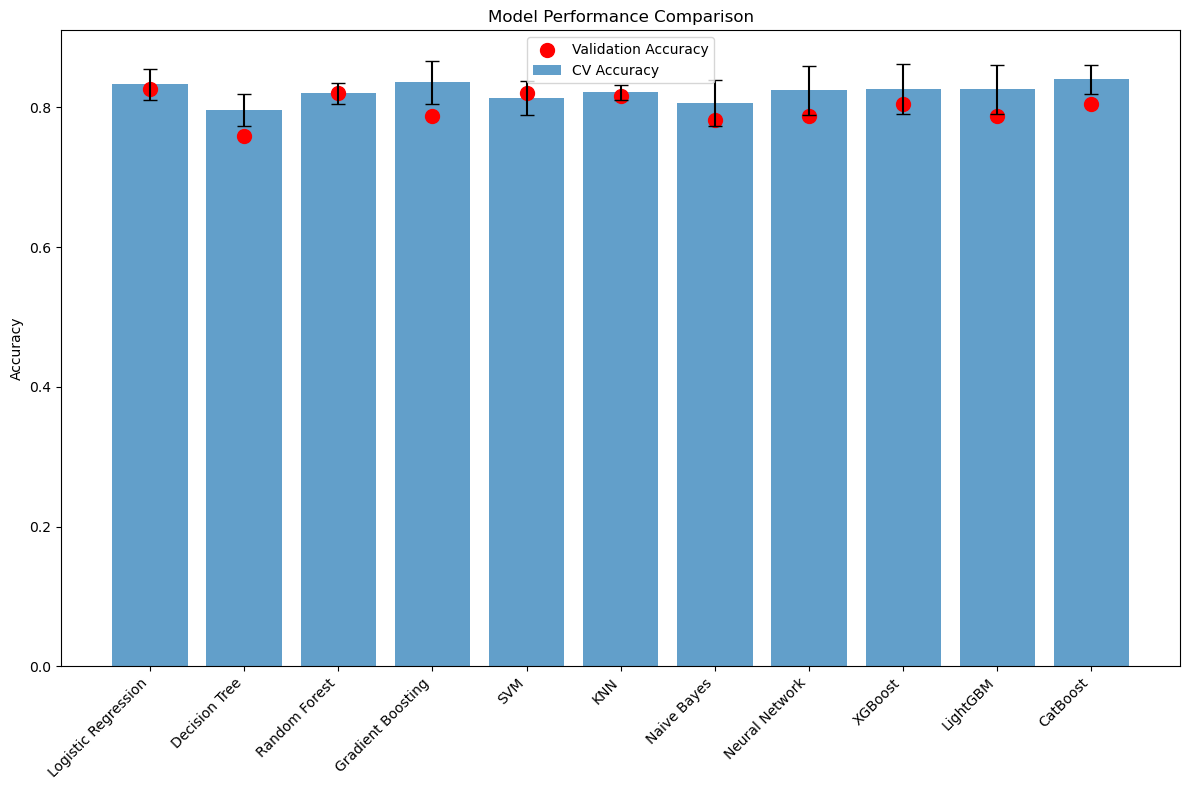


Models ranked by validation accuracy:
1. Logistic Regression: 0.8268 (CV: 0.8329 ± 0.0218)
2. Random Forest: 0.8212 (CV: 0.8203 ± 0.0153)
3. SVM: 0.8212 (CV: 0.8132 ± 0.0247)
4. KNN: 0.8156 (CV: 0.8217 ± 0.0109)
5. XGBoost: 0.8045 (CV: 0.8259 ± 0.0357)
6. CatBoost: 0.8045 (CV: 0.8400 ± 0.0209)
7. Gradient Boosting: 0.7877 (CV: 0.8357 ± 0.0312)
8. Neural Network: 0.7877 (CV: 0.8245 ± 0.0348)
9. LightGBM: 0.7877 (CV: 0.8259 ± 0.0348)
10. Naive Bayes: 0.7821 (CV: 0.8062 ± 0.0334)
11. Decision Tree: 0.7598 (CV: 0.7964 ± 0.0230)

Top 3 models selected for hyperparameter tuning: Logistic Regression, Random Forest, SVM


In [18]:
# Visualizing model performance
model_names = list(results.keys())
cv_means = [results[name]['CV_mean'] for name in model_names]
cv_stds = [results[name]['CV_std'] for name in model_names]
val_accs = [results[name]['Val_accuracy'] for name in model_names]

plt.figure(figsize=(12, 8))
plt.bar(model_names, cv_means, yerr=cv_stds, alpha=0.7, capsize=5, label='CV Accuracy')
plt.scatter(model_names, val_accs, color='red', s=100, label='Validation Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# Sorting models by validation accuracy
sorted_results = sorted(results.items(), key=lambda x: x[1]['Val_accuracy'], reverse=True)

print("\nModels ranked by validation accuracy:")
for i, (name, result) in enumerate(sorted_results):
    print(f"{i+1}. {name}: {result['Val_accuracy']:.4f} (CV: {result['CV_mean']:.4f} ± {result['CV_std']:.4f})")

# Top models for further tuning
top_models = [name for name, _ in sorted_results[:3]]
print(f"\nTop 3 models selected for hyperparameter tuning: {', '.join(top_models)}")

In [5]:
# Hyperparameter Tuning for Top Models

# Importing required distributions for hyperparameter tuning
from scipy.stats import uniform, randint

# 1. Hyperparameter tuning for Logistic Regression
print("Hyperparameter tuning for Logistic Regression...")
logreg_params = {
    'C': uniform(0.001, 100),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500, 1000]
}

logreg_random = RandomizedSearchCV(
    LogisticRegression(random_state=42),
    param_distributions=logreg_params,
    n_iter=50,
    cv=cv,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

logreg_random.fit(X_train, y_train)
print("Best Logistic Regression parameters:", logreg_random.best_params_)
print("Best Logistic Regression CV score:", logreg_random.best_score_)

# Evaluating on validation set
best_logreg = logreg_random.best_estimator_
logreg_val_preds = best_logreg.predict(X_val)
logreg_val_acc = accuracy_score(y_val, logreg_val_preds)
print("Logistic Regression validation accuracy:", logreg_val_acc)

Hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Logistic Regression parameters: {'C': np.float64(0.7076305219717406), 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression CV score: 0.825874125874126
Logistic Regression validation accuracy: 0.8212290502793296


In [6]:
# 2. Hyperparameter tuning for Random Forest
print("\nHyperparameter tuning for Random Forest...")
rf_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=rf_params,
    n_iter=50,
    cv=cv,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train, y_train)
print("Best Random Forest parameters:", rf_random.best_params_)
print("Best Random Forest CV score:", rf_random.best_score_)

# Evaluating on validation set
best_rf = rf_random.best_estimator_
rf_val_preds = best_rf.predict(X_val)
rf_val_acc = accuracy_score(y_val, rf_val_preds)
print("Random Forest validation accuracy:", rf_val_acc)


Hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Random Forest parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 326}
Best Random Forest CV score: 0.8413670836206049
Random Forest validation accuracy: 0.8100558659217877


In [19]:
# Skipping SVM tuning for efficiency

In [20]:
# Comparing the tuned models
print("\nComparison of Tuned Models:")
print(f"Logistic Regression: CV Accuracy = {logreg_random.best_score_:.4f}, Validation Accuracy = {logreg_val_acc:.4f}")
print(f"Random Forest: CV Accuracy = {rf_random.best_score_:.4f}, Validation Accuracy = {rf_val_acc:.4f}")

# Selecting the best model
best_model_name = ""
best_model = None
best_accuracy = 0

if logreg_val_acc > best_accuracy:
    best_accuracy = logreg_val_acc
    best_model = best_logreg
    best_model_name = "Logistic Regression"

if rf_val_acc > best_accuracy:
    best_accuracy = rf_val_acc
    best_model = best_rf
    best_model_name = "Random Forest"

print(f"\nBest Model: {best_model_name} with validation accuracy of {best_accuracy:.4f}")


Comparison of Tuned Models:
Logistic Regression: CV Accuracy = 0.8259, Validation Accuracy = 0.8212
Random Forest: CV Accuracy = 0.8414, Validation Accuracy = 0.8101

Best Model: Logistic Regression with validation accuracy of 0.8212


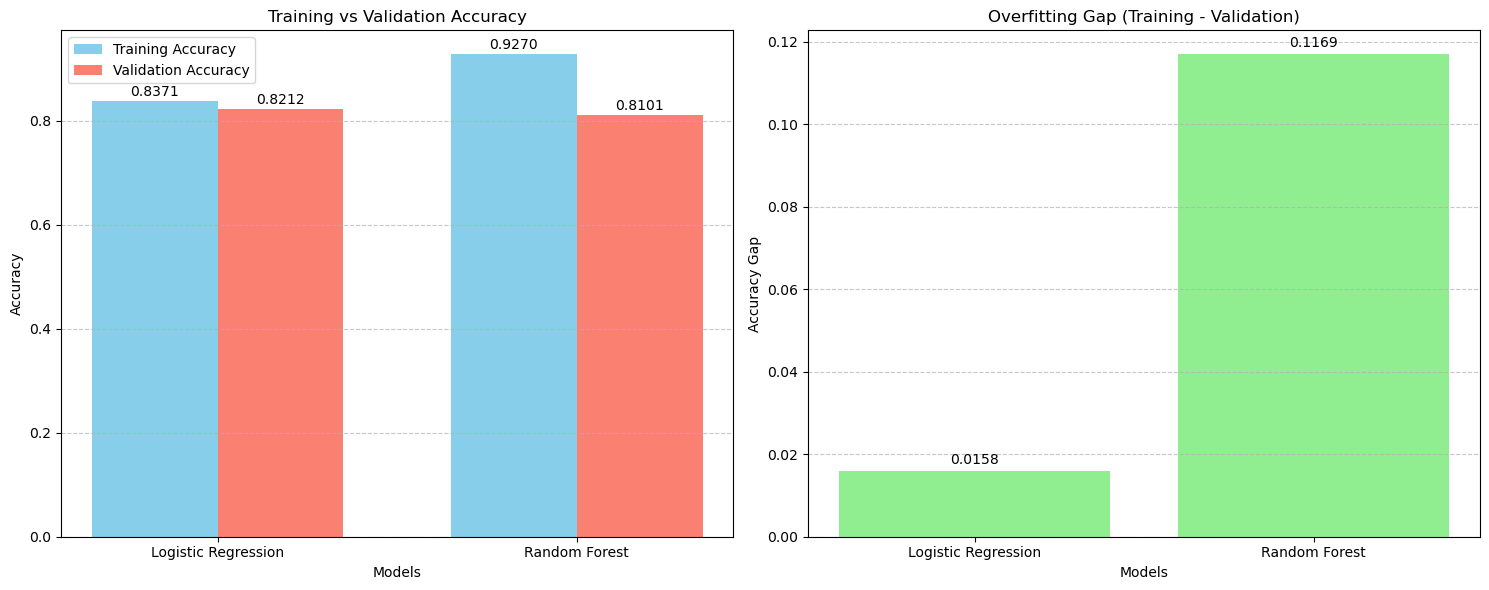

Overfitting Analysis:
Logistic Regression:
  Training Accuracy: 0.8371
  Validation Accuracy: 0.8212
  Gap (Overfitting Indicator): 0.0158
  Assessment: Minimal overfitting - model generalizes well

Random Forest:
  Training Accuracy: 0.9270
  Validation Accuracy: 0.8101
  Gap (Overfitting Indicator): 0.1169
  Assessment: Significant overfitting - model is memorizing training data



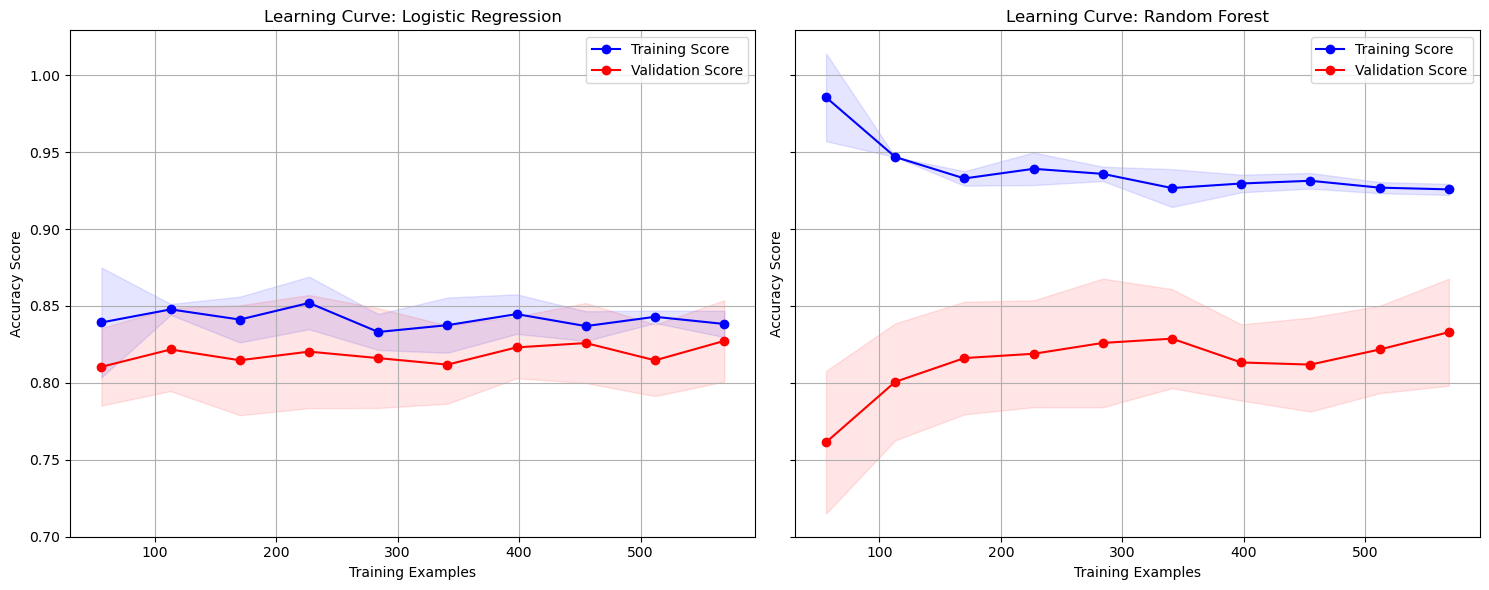

In [22]:
# Analyzing overfitting
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Setting up the figure for model comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Preparing data for plotting
model_names = ['Logistic Regression', 'Random Forest']
train_accuracies = []
val_accuracies = []

# Calculating training accuracies for each model
# For Logistic Regression
train_preds_lr = best_logreg.predict(X_train)
train_acc_lr = accuracy_score(y_train, train_preds_lr)
train_accuracies.append(train_acc_lr)
val_accuracies.append(logreg_val_acc)

# For Random Forest
train_preds_rf = best_rf.predict(X_train)
train_acc_rf = accuracy_score(y_train, train_preds_rf)
train_accuracies.append(train_acc_rf)
val_accuracies.append(rf_val_acc)

# Plotting training vs validation accuracies
x = np.arange(len(model_names))
width = 0.35

ax1.bar(x - width/2, train_accuracies, width, label='Training Accuracy', color='skyblue')
ax1.bar(x + width/2, val_accuracies, width, label='Validation Accuracy', color='salmon')

ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training vs Validation Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Adding accuracy values on top of bars
for i, (train_acc, val_acc) in enumerate(zip(train_accuracies, val_accuracies)):
    ax1.text(i - width/2, train_acc + 0.005, f'{train_acc:.4f}', ha='center', va='bottom')
    ax1.text(i + width/2, val_acc + 0.005, f'{val_acc:.4f}', ha='center', va='bottom')

# Calculating the gap between training and validation accuracy
gaps = [train_acc - val_acc for train_acc, val_acc in zip(train_accuracies, val_accuracies)]

# Plotting the overfitting gap
ax2.bar(model_names, gaps, color='lightgreen')
ax2.set_xlabel('Models')
ax2.set_ylabel('Accuracy Gap')
ax2.set_title('Overfitting Gap (Training - Validation)')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Adding gap values on top of bars
for i, gap in enumerate(gaps):
    ax2.text(i, gap + 0.001, f'{gap:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Printing the analysis
print("Overfitting Analysis:")
print("=" * 50)
for name, train_acc, val_acc, gap in zip(model_names, train_accuracies, val_accuracies, gaps):
    print(f"{name}:")
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Gap (Overfitting Indicator): {gap:.4f}")
    if gap < 0.02:
        print("  Assessment: Minimal overfitting - model generalizes well")
    elif gap < 0.05:
        print("  Assessment: Moderate overfitting - acceptable but could be improved")
    else:
        print("  Assessment: Significant overfitting - model is memorizing training data")
    print()

# Setting up the figure for learning curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Defining the models and their names
models = [best_logreg, best_rf]
titles = ['Logistic Regression', 'Random Forest']

# Creating learning curves for each model
for idx, (model, title, ax) in enumerate(zip(models, titles, axes)):
    # Generating learning curve data
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=5, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy', n_jobs=-1
    )
    
    # Calculating mean and standard deviation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plotting learning curve
    ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    
    ax.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    
    # Setting labels and title
    ax.set_title(f'Learning Curve: {title}')
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Accuracy Score')
    ax.legend(loc='best')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Using just the tuned Logistic Regression (which showed minimal overfitting)
print("Training Logistic Regression on full training data...")
final_model = best_logreg

# Fitting on all training data
final_model.fit(X, y)

# Making predictions on the test set
print("Generating predictions for test set...")
test_predictions = final_model.predict(X_test)

# Loading the original test data to get PassengerId
original_test = pd.read_csv("data/test.csv")

# Creating the submission file
submission = pd.DataFrame({
    'PassengerId': original_test['PassengerId'],
    'Survived': test_predictions.astype(int)
})

# Saving the submission file
submission.to_csv('submission_simple.csv', index=False)
print("Simple submission created successfully!")

# Checking the distribution
print("\nPrediction distribution:")
print(submission['Survived'].value_counts())
print(f"Survival rate in predictions: {submission['Survived'].mean():.2%}")

Training Logistic Regression on full training data...
Generating predictions for test set...
Simple submission created successfully!

Prediction distribution:
Survived
0    269
1    149
Name: count, dtype: int64
Survival rate in predictions: 35.65%


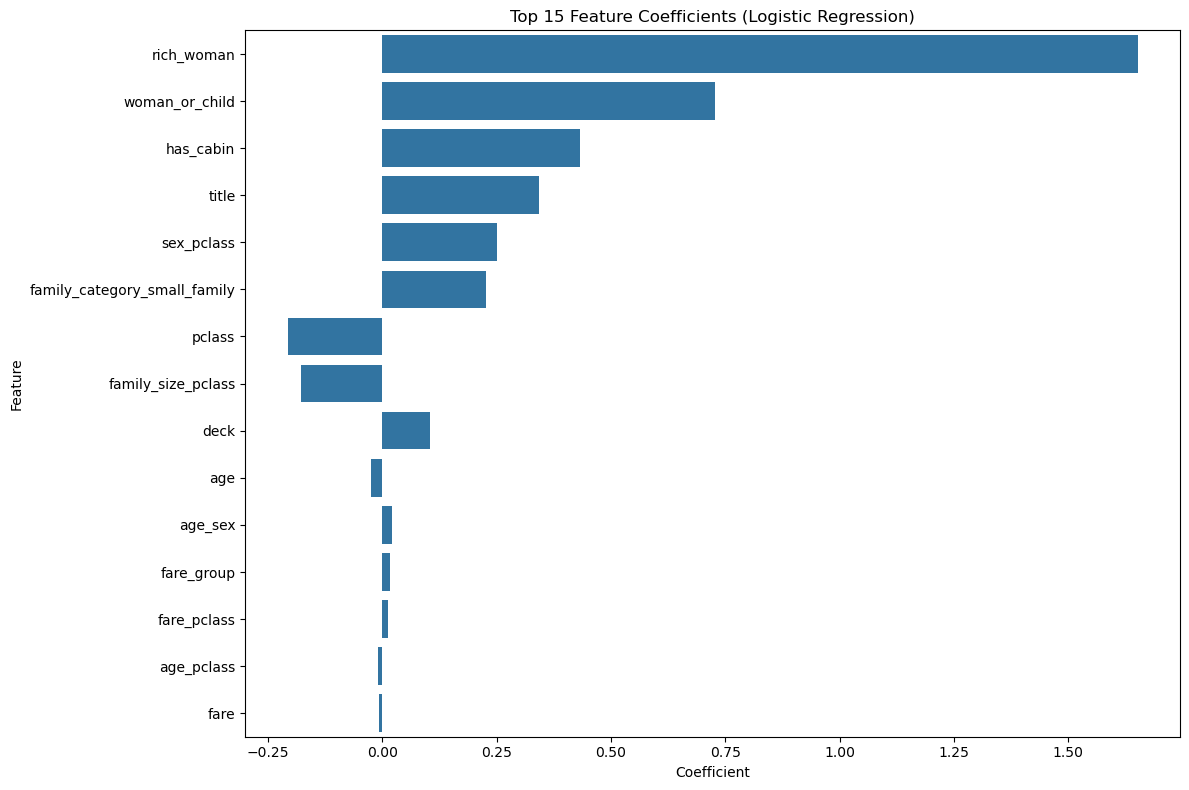

Top 15 most important features:
                         Feature  Coefficient  Abs_Coefficient
5                     rich_woman     1.651474         1.651474
3                 woman_or_child     0.726790         0.726790
12                     has_cabin     0.431575         0.431575
9                          title     0.342164         0.342164
7                     sex_pclass     0.250695         0.250695
18  family_category_small_family     0.226381         0.226381
16                        pclass    -0.207288         0.207288
2             family_size_pclass    -0.178370         0.178370
0                           deck     0.103523         0.103523
11                           age    -0.026021         0.026021
15                       age_sex     0.020462         0.020462
14                    fare_group     0.017309         0.017309
17                   fare_pclass     0.011241         0.011241
1                     age_pclass    -0.010751         0.010751
8                      

In [ ]:
# Using feature importance from Logistic Regression
# Feature coefficients
coef = best_logreg.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coef,
    'Abs_Coefficient': np.abs(coef)
}).sort_values('Abs_Coefficient', ascending=False)

# Top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Coefficients (Logistic Regression)')
plt.tight_layout()
plt.show()

print("Top 15 most important features:")
print(feature_importance.head(15))
print(feature_importance.head(15))

# Top features
top_features = feature_importance.head(12)['Feature'].tolist()
print("Selected top features:", top_features)

# Simplified datasets
X_top = X[top_features]
X_test_top = X_test[top_features]

# Model training on top features
print("\nTraining Logistic Regression on top features...")
top_model = LogisticRegression(max_iter=1000, random_state=42)
top_model.fit(X_top, y)

# Cross-validation
cv_scores = cross_val_score(top_model, X_top, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Predictions
top_predictions = top_model.predict(X_test_top)

# Submission
submission_top = pd.DataFrame({
    'PassengerId': original_test['PassengerId'],
    'Survived': top_predictions.astype(int)
})

submission_top.to_csv('submission_top_features.csv', index=False)
print("Top features submission created!")

In [25]:
'''
Learning:
- In small datasets like Titanic (n=891), simpler models with carefully selected features often outperform complex approaches
- Complex models (Random Forest, CatBoost) were severely overfitting
- The top features approach succeeded because it:
    * By selecting only the most important features based on Logistic Regression coefficients, we filtered out the noise
    * Focused on quality over quantity of features
    * Used Logistic Regression that's naturally resistant to overfitting

'''

"\nLearning:\n- In small datasets like Titanic (n=891), simpler models with carefully selected features often outperform complex approaches\n- Complex models (Random Forest, CatBoost) were severely overfitting\n- The top features approach succeeded because it:\n    * By selecting only the most important features based on Logistic Regression coefficients, we filtered out the noise\n    * Focused on quality over quantity of features\n    * Used Logistic Regression that's naturally resistant to overfitting\n\n"